# Plot OSG Percentiles with Current HRRR Forecasts for a Point

In [33]:
%matplotlib inline

import h5py
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
from datetime import datetime, timedelta
# import multiprocessing # plotting with multiprocessing doesn't work correctly in notebooks

from mpl_toolkits.basemap import Basemap

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v2')
from BB_downloads.HRRR_S3 import *
from BB_wx_calcs.wind import wind_uv_to_spd
from BB_data.grid_manager import pluck_point_new
from BB_MesoWest.MesoWest_STNinfo import get_MW_location_dict

from matplotlib.dates import DateFormatter
formatter = DateFormatter('%b %d\n%H:%M')

import matplotlib as mpl 
mpl.rcParams['figure.figsize'] = [8, 6]
mpl.rcParams['figure.titlesize'] = 15
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['lines.linewidth'] = 1.8
mpl.rcParams['grid.linewidth'] = .25
mpl.rcParams['figure.subplot.wspace'] = 0.05
mpl.rcParams['figure.subplot.hspace'] = 0.05
mpl.rcParams['legend.fontsize'] = 8
mpl.rcParams['legend.framealpha'] = .75
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.dpi'] = 100

In [34]:
DATE = datetime(2018, 2, 18, 12)
fxx = 2
stn = 'WBB'

var = 'REFC:entire'

# MesoWest Station Info
LD = get_MW_location_dict(stn)
MWlat = LD[stn]['latitude']
MWlon = LD[stn]['longitude']

if var == 'TMP:2 m':
    ymin = -20
    ymax = 30
elif var == 'DPT:2 m':
    ymin = -25
    ymax = 15
elif var == 'REFC:entire':
    ymin = -10
    ymax = 50
elif var == 'UVGRD:10 m':
    ymin = 0
    ymax = 20
elif var == 'UVGRD:80 m':
    ymin = 0
    ymax = 30
else:
    ymin = 0
    ymax = 20

In [35]:
# Load HRRR lat/lon Grid
DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/'
latlon_file = h5py.File(DIR+'OSG_HRRR_latlon.h5', 'r')
lat = latlon_file['latitude'].value
lon = latlon_file['longitude'].value

In [36]:
# Pluck point
point = pluck_point_new(MWlat, MWlon, lat, lon)
x = point[0][0]
y = point[1][0]

print lat[x,y], MWlat, 'and',lon[x,y], MWlon

40.75462 40.76623 and -111.83506 -111.84755


## Get OSG Percentiles for a Point

In [37]:
variable = var.replace(':', '_').replace(' ', '_')
DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/%s/' % (variable)
FILE = 'OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % ((variable, DATE.month, DATE.day, DATE.hour))
print DIR+FILE

percentiles = [0,1,2,3,4,5,10,25,33,50,66,75,90,95,96,97,98,99,100]
PP = np.array([])
with h5py.File(DIR+FILE, 'r') as f:
    for i in percentiles:
        PP = np.append(PP, f["p%02d" % i][x][y])

# Convert Units
if var == 'TMP:2 m' or var == 'DPT:2 m':
    PP -= 273.15

/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/REFC_entire/OSG_HRRR_REFC_entire_m02_d18_h12_f00.h5


In [38]:
RUN = DATE-timedelta(hours=fxx)
H = get_hrrr_variable(DATE, var, fxx=fxx, verbose=False)

if var == 'TMP:2 m' or var == 'DPT:2 m':
    Hpoint = H['value'][x][y]-273.15
else:
    Hpoint = H['value'][x][y]

percentiles = [0,1,2,3,4,5,10,25,33,50,66,75,90,95,96,97,98,99,100]

In [39]:
# Linear interpolation to find the percentile for the value
if Hpoint >= np.max(PP):
    Y = Hpoint
    X = 100
elif Hpoint <= np.min(PP):
    Y = Hpoint
    X = 0
else:
    y1 = np.min(filter(lambda x: x>=Hpoint, PP))
    y2 = np.max(filter(lambda x: x<=Hpoint, PP))
    y1_idx = np.where(PP==y1)[0][0]
    y2_idx = np.where(PP==y2)[0][0]
    x1 = percentiles[y1_idx]
    x2 = percentiles[y2_idx]
    
    print 'x1, y1:', (x1, y1)
    print 'x2, y2:', (x2, y2)

    print 'Hpoint:', Hpoint
    m = (y2-y1)/(x2-x1)
    b = 0-m*x1+y1

    Y = Hpoint
    X = (Y-b)/m

    print 'm:', m
    print 'b:', b

print 'X:', X
print 'Y:', Y

x1, y1: (95, 24.466000000000001)
x2, y2: (90, 14.281000000000001)
Hpoint: 15.6875
m: 2.037
b: -169.049
X: 90.6904761905
Y: 15.6875


In [40]:
H.keys()

['lon', 'value', 'msg', 'valid', 'lat', 'anlys']

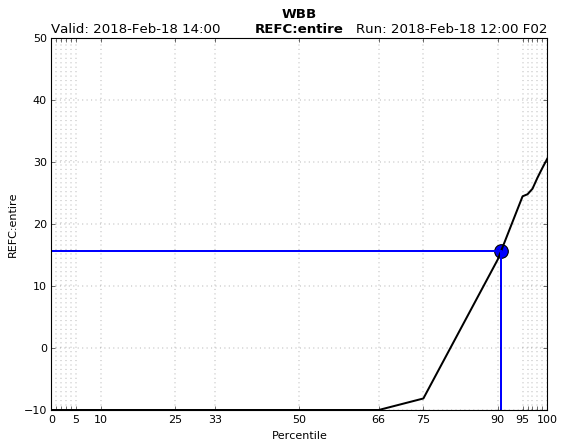

In [48]:
# Plot Percentile Curve
plt.plot(percentiles, PP, color='k')

# Plot Current HRRR Value
plt.axhline(Hpoint, xmax=X/100)
plt.axvline(X, ymax=(Hpoint-ymin)/(ymax-ymin))
plt.scatter(X,Hpoint, s=150)

plt.grid()

plt.xlabel('Percentile')
tick_labels = [0,'','','','',5, 10, 25, 33, 50, 66, 75, 90, 95, '', '', '','',100]
plt.xticks(percentiles, tick_labels)
plt.xlim([0,100])
plt.ylabel(var)
plt.ylim([ymin, ymax])

plt.title('Valid: %s' % H['valid'].strftime('%Y-%b-%d %H:%M'), loc='Left')
plt.title('%s\n%s' % (stn, var), loc='Center', fontweight='bold')
plt.title('Run: %s F%02d' % (H['anlys'].strftime("%Y-%b-%d %H:%M"), fxx), loc='right')


## Loop a Whole Day and forecast hours: Point

/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/TMP_2_m/OSG_HRRR_TMP_2_m_m02_d16_h00_f00.h5
/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/TMP_2_m/OSG_HRRR_TMP_2_m_m02_d15_h23_f00.h5
/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/TMP_2_m/OSG_HRRR_TMP_2_m_m02_d15_h22_f00.h5
/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/TMP_2_m/OSG_HRRR_TMP_2_m_m02_d15_h21_f00.h5
/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/TMP_2_m/OSG_HRRR_TMP_2_m_m02_d15_h20_f00.h5
/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/TMP_2_m/OSG_HRRR_TMP_2_m_m02_d15_h19_f00.h5
/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/TMP_2_m/OSG_HRRR_TMP_2_m_m02_d15_h18_f00.h5
/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/TMP_2_m/OSG_HRRR_TMP_2_m_m02_d15_h17_f00.h5
/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/

TypeError: 'float' object has no attribute '__getitem__'

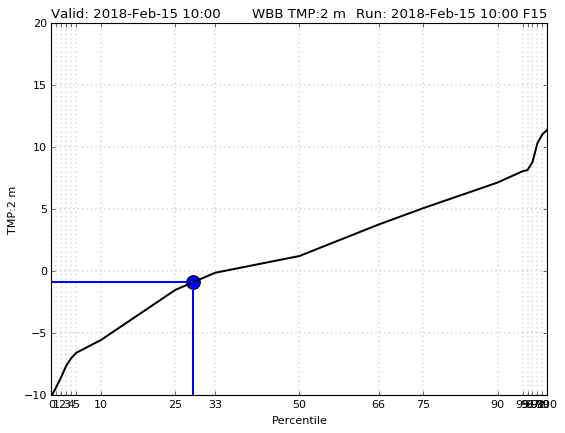

In [5]:
fxx = range(0,19)

variable = var.replace(':', '_').replace(' ', '_')
DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/%s/' % (variable)

percentiles = [0,1,2,3,4,5,10,25,33,50,66,75,90,95,96,97,98,99,100]

DATES = [DATE-timedelta(hours=h) for h in range(0,24)]

for i, D in enumerate(DATES):
    FILE = 'OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % ((variable, D.month, D.day, D.hour))
    print DIR+FILE

    PP = np.array([])
    with h5py.File(DIR+FILE, 'r') as f:
        for i in percentiles:
            PP = np.append(PP, f["p%02d" %i][x][y])

    # Convert Units
    if var == 'TMP:2 m' or var == 'DPT:2 m':
        PP -= 273.15

    for f in fxx:   
        run = D-timedelta(hours=f)
        H = get_hrrr_variable(run, var, fxx=f, verbose=False)
        Hpoint = H['value'][x][y]-273.15

        # Linear interpolation to find the percentile for the value
        if Hpoint >= np.max(PP):
            Y = Hpoint
            X = 100
        elif Hpoint <= np.min(PP):
            Y = Hpoint
            X = 0
        else:
            y1 = np.min(filter(lambda x: x>=Hpoint, PP))
            y2 = np.max(filter(lambda x: x<=Hpoint, PP))
            y1_idx = np.where(PP==y1)[0][0]
            y2_idx = np.where(PP==y2)[0][0]
            x1 = percentiles[y1_idx]
            x2 = percentiles[y2_idx]

            m = (y2-y1)/(x2-x1)
            b = 0-m*x1+y1

            Y = Hpoint
            X = (Y-b)/m
        
        ## Plot
        # Plot Percentile Curve
        plt.clf()
        plt.cla()
        # Plot Percentile Curve
        plt.plot(percentiles, PP, color='k')

        # Plot Current HRRR Value
        plt.axhline(Hpoint, xmax=X/100)
        plt.axvline(X, ymax=(10+Hpoint)/30)
        plt.scatter(X, Hpoint, s=150)

        plt.grid()

        plt.xlabel('Percentile')
        tick_labels = [0,'','','','',5, 10, 25, 33, 50, 66, 75, 90, 95, '', '', '','',100]
        plt.xticks(percentiles, tick_labels)
        plt.xlim([0,100])
        plt.ylabel(var)
        plt.ylim([-10, 20])
        plt.title('Valid: %s' % D.strftime('%Y-%b-%d %H:%M'), loc='Left')
        plt.title('%s %s' % (stn, var), loc='Center')
        plt.title('Run: %s F%02d' % (D.strftime("%Y-%b-%d %H:%M"), f), loc='right')

        plt.savefig('/uufs/chpc.utah.edu/common/home/u0553130/public_html/PhD/HRRR/OSG/point_current_HRRR/%s_f%02d.png' % (D.strftime('%Y-%m-%d_%H'), f))

---

## Area Percentiles and Current HRRR

/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/REFC_entire/OSG_HRRR_REFC_entire_m02_d18_h14_f00.h5
x1, y1: (90, 14.025)
x2, y2: (75, -10.0)
Hpoint: -3.875
m: 1.60166666667
b: -130.125
0 (78.824141519250773, -3.875)
-------
Station: (88.231323864252417, 15.6875)


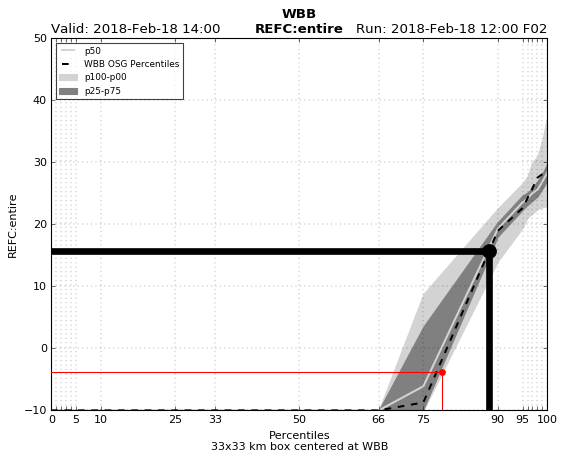

In [57]:
## Area Percentiles and Current HRRR
var = 'REFC:entire'
D = datetime(2018, 2, 18, 14)
f = 2

variable = var.replace(':', '_').replace(' ', '_')
DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/%s/' % (variable)

percentiles = [0,1,2,3,4,5,10,25,33,50,66,75,90,95,96,97,98,99,100]
box_radius = 5


if var == 'TMP:2 m':
    ymin = -20
    ymax = 30
elif var == 'DPT:2 m':
    ymin = -25
    ymax = 15
elif var == 'REFC:entire':
    ymin = -10
    ymax = 50
elif var == 'UVGRD:10 m':
    ymin = 0
    ymax = 20
elif var == 'UVGRD:80 m':
    ymin = 0
    ymax = 30
else:
    ymin = 0
    ymax = 20



## Get area OSG percentiles from the bounding box for each percentile
FILE = 'OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % ((variable, D.month, D.day, D.hour))
print DIR+FILE

with h5py.File(DIR+FILE, 'r') as ff:
    for i in percentiles:
        pp = ff["p%02d" %i][x-box_radius:x+box_radius+1,y-box_radius:y+box_radius+1]
        if i == 0:
            PP = pp
        else:
            PP = np.dstack([PP, pp])

## Convert Units
if var == 'TMP:2 m' or var == 'DPT:2 m':
    PP -= 273.15

## Clalculate area percentiles from the OSG percentiles
for i in range(19):
    p = np.percentile(PP[:,:,i], [0, 25, 50, 75, 100])
    if i == 0:
        area_P = p
    else:
        area_P = np.dstack([area_P, p])


## For this valid date, loop through each forecast hour

## HRRR Model Run date
RUN = D-timedelta(hours=f)

## Get HRRR data for this run
if var.split(':')[0] == 'UVGRD':
    # Calculate wind speed from U and V components
    level = var.split(':')[1]
    HU = get_hrrr_variable(RUN, 'UGRD:'+level, fxx=f, value_only=True, verbose=False)    
    HV = get_hrrr_variable(RUN, 'VGRD:'+level, fxx=f, value_only=True, verbose=False)
    speed = wind_uv_to_spd(HU['value'], HV['value'])
    H = HU
    H['value'] = speed
else:
    H = get_hrrr_variable(RUN, var, fxx=f, verbose=False)


## Convert units and get values in bounding box area
if var == 'TMP:2 m' or var == 'DPT:2 m':
    Hpoint = H['value'][x,y]-273.15
    Harea = H['value'][x-box_radius:x+box_radius+1,y-box_radius:y+box_radius+1]-273.15    
else:
    Hpoint = H['value'][x,y]
    Harea = H['value'][x-box_radius:x+box_radius+1,y-box_radius:y+box_radius+1]


## Calculate the HRRR percentiles in the boxed area for this run
HP = np.percentile(Harea, [0,25,50,75,100])


## --- Plot OSG percentiles ---------------------------------------

plt.fill_between(percentiles, area_P[0][0], area_P[0][4],
                 color='lightgrey',
                 label='p100-p00',
                 zorder=1)
plt.fill_between(percentiles, area_P[0][1], area_P[0][3],
                 color='grey',
                 label='p25-p75',
                 zorder=1)
plt.plot(percentiles, area_P[0][2],
         color='lightgrey',
         label="p50",
         zorder=1)
## Plot all percentiles for each grid box
#for i in range(box_radius*2+1):
#    for j in range(box_radius*2+1):
#        plt.plot(percentiles, PP[i,j,:])


## Plot OSG percentiles for the single grid box nearest the station of interest
plt.plot(percentiles, PP[box_radius,box_radius,:],
         linestyle='--',
         color='k',
         label='%s OSG Percentiles' % stn,
         zorder=1)


## --- Plot RUN percentiles -------------------------------------
# Linear interpolation to find the percentile for the value
for i in range(1):
    p100Hpoint = HP[i]
    p100PP = area_P[0][i]
    if p100Hpoint > np.max(p100PP):
        p100Y = p100Hpoint
        p100X = 100
        print "Hpoint > PP, exceeds p100", D, f
    elif p100Hpoint < np.min(p100PP):
        p100Y = p100Hpoint
        p100X = 0
        print "Hpoint < PP exceeds p00", D, f,
    else:
        p100y1 = np.min(filter(lambda x: x>=p100Hpoint, p100PP))
        p100y1_idx = np.where(p100PP==p100y1)[0][0]
        p100x1 = percentiles[p100y1_idx]
        p100y2 = p100PP[p100y1_idx-1] #y2 and y1 index are one behind x1,y1
        p100x2 = percentiles[p100y1_idx-1]
        p100m = (p100y2-p100y1)/(p100x2-p100x1)
        p100b = 0-p100m*p100x1+p100y1
        p100Y = p100Hpoint
        p100X = (p100Y-p100b)/p100m
        print 'x1, y1:', (p100x1, p100y1)
        print 'x2, y2:', (p100x2, p100y2)
        print 'Hpoint:', p100Hpoint
        print 'm:', p100m
        print 'b:', p100b
        print i, (p100X, p100Y)
        print "-------"
    plt.axhline(p100Hpoint, xmax=p100X/100, color='r', linewidth=1, zorder=50)
    plt.axvline(p100X, ymax=(p100Hpoint-ymin)/(ymax-ymin), color='r', linewidth=1, zorder=50)
    plt.scatter(p100X, p100Hpoint, s=25, color='r', zorder=50)
## Plot value from current HRRR run for every grid box
#for i in range(box_radius*2+1):
#    for j in range(box_radius*2+1):
#        plt.axhline(Harea[i,j], linewidth=.1)

## Plot HRRR value for stn grid box for urrent HRRR run
# Linear interpolation to find the percentile for the value
stnPP = PP[box_radius,box_radius,:]
if Hpoint > np.max(stnPP):
    Y = Hpoint
    X = 100
    print "station Hpoint > PP, exceeds p100", D, f
elif Hpoint < np.min(stnPP):
    Y = Hpoint
    X = 0
    print "station Hpoint < PP, exceeds p00", D, f
else:
    y1 = np.min(filter(lambda x: x>=Hpoint, stnPP))
    y1_idx = np.where(stnPP==y1)[0][0]
    x1 = percentiles[y1_idx]
    y2 = stnPP[y1_idx-1]
    x2 = percentiles[y1_idx-1]
    m = (y2-y1)/(x2-x1)
    b = 0-m*x1+y1
    Y = Hpoint
    X = (Y-b)/m
    print 'Station:', (X, Y)
plt.axhline(Hpoint, xmax=X/100, color='k', lw=6, zorder=100)
plt.axvline(X, ymax=(Hpoint-ymin)/(ymax-ymin), color='k', lw=6, zorder=100)
plt.scatter(X, Hpoint, s=150, color='k', zorder=100)


## --- Other Plot Elements --------------------------------------
plt.grid()
plt.legend(loc='upper left')

plt.xlabel('Percentiles\n%sx%s km box centered at %s' % (np.shape(PP)[0]*3, np.shape(PP)[0]*3, stn))
tick_labels = [0,'','','','',5, 10, 25, 33, 50, 66, 75, 90, 95, '', '', '','',100]
plt.xticks(percentiles, tick_labels)
plt.xlim([0,100])
plt.ylabel(var)
plt.ylim([ymin, ymax])

plt.title('Valid: %s' % H['valid'].strftime('%Y-%b-%d %H:%M'), loc='Left')
plt.title('%s\n%s' % (stn, var), loc='Center', fontweight='bold')
plt.title('Run: %s F%02d' % (H['anlys'].strftime("%Y-%b-%d %H:%M"), f), loc='right')

## Loop Area Percentiles and Current HRRR

In [123]:
## Area Percentiles and Current HRRR

var = 'TMP:2 m'
var = 'UVGRD:10 m'
var = 'DPT:2 m'
#var = 'REFC:entire'

variable = var.replace(':', '_').replace(' ', '_')
DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/%s/' % (variable)

percentiles = [0,1,2,3,4,5,10,25,33,50,66,75,90,95,96,97,98,99,100]
box_radius = 5

sDATE = datetime(2018, 2, 18, 0)
DATES = [sDATE+timedelta(hours=h) for h in range(24)]

if var == 'TMP:2 m':
    ymin = -20
    ymax = 30
elif var == 'DPT:2 m':
    ymin = -25
    ymax = 15
elif var == 'REFC:entire':
    ymin = -10
    ymax = 50
elif var == 'UVGRD:10 m':
    ymin = 0
    ymax = 20
elif var == 'UVGRD:80 m':
    ymin = 0
    ymax = 30
else:
    ymin = 0
    ymax = 20

for D in DATES:

    ## Get area OSG percentiles from the bounding box for each percentile
    FILE = 'OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % ((variable, D.month, D.day, D.hour))
    print DIR+FILE
    
    with h5py.File(DIR+FILE, 'r') as ff:
        for i in percentiles:
            pp = ff["p%02d" %i][x-box_radius:x+box_radius+1,y-box_radius:y+box_radius+1]
            if i == 0:
                PP = pp
            else:
                PP = np.dstack([PP, pp])

    ## Convert Units
    if var == 'TMP:2 m' or var == 'DPT:2 m':
        PP -= 273.15

    ## Clalculate area percentiles from the OSG percentiles
    for i in range(19):
        p = np.percentile(PP[:,:,i], [0, 25, 50, 75, 100])
        if i == 0:
            area_P = p
        else:
            area_P = np.dstack([area_P, p])
    
    
    ## For this valid date, loop through each forecast hour
    for f in range(19):
        plt.clf()
        plt.cla()
        
        ## HRRR Model Run date
        RUN = D-timedelta(hours=f)
        
        ## Get HRRR data for this run
        if var.split(':')[0] == 'UVGRD':
            # Calculate wind speed from U and V components
            level = var.split(':')[1]
            HU = get_hrrr_variable(RUN, 'UGRD:'+level, fxx=f, value_only=True, verbose=False)    
            HV = get_hrrr_variable(RUN, 'VGRD:'+level, fxx=f, value_only=True, verbose=False)
            speed = wind_uv_to_spd(HU['value'], HV['value'])
            H = HU
            H['value'] = speed
        else:
            H = get_hrrr_variable(RUN, var, fxx=f, value_only=True, verbose=False)

        
        ## Convert units and get values in bounding box area
        if var == 'TMP:2 m' or var == 'DPT:2 m':
            Hpoint = H['value'][x,y]-273.15
            Harea = H['value'][x-box_radius:x+box_radius+1,y-box_radius:y+box_radius+1]-273.15    
        else:
            Hpoint = H['value'][x,y]
            Harea = H['value'][x-box_radius:x+box_radius+1,y-box_radius:y+box_radius+1]
        
        
        ## Calculate the HRRR percentiles in the boxed area for this run
        HP = np.percentile(Harea, [0,25,50,75,100])

        
        ## --- Plot OSG percentiles ---------------------------------------
        plt.fill_between(percentiles, area_P[0][0], area_P[0][4],
                         color='lightgrey',
                         label='p100-p00',
                         zorder=1)
        plt.fill_between(percentiles, area_P[0][1], area_P[0][3],
                         color='grey',
                         label='p25-p75',
                         zorder=1)
        plt.plot(percentiles, area_P[0][2],
                 color='lightgrey',
                 label="p50",
                 zorder=1)
        ## Plot all percentiles for each grid box
        #for i in range(box_radius*2+1):
        #    for j in range(box_radius*2+1):
        #        plt.plot(percentiles, PP[i,j,:])
        
        
        ## Plot OSG percentiles for the single grid box nearest the station of interest
        plt.plot(percentiles, PP[box_radius,box_radius,:],
                 linestyle='--',
                 color='k',
                 label='%s OSG Percentiles' % stn,
                 zorder=1)

        
        ## --- Plot RUN percentiles -------------------------------------
        # Linear interpolation to find the percentile for the value
        for i in range(5):
            p100Hpoint = HP[i]
            p100PP = area_P[0][i]
            if p100Hpoint > np.max(p100PP):
                p100Y = p100Hpoint
                p100X = 100
                print "Hpoint > PP, exceeds p100", D, f
            elif p100Hpoint < np.min(p100PP):
                p100Y = p100Hpoint
                p100X = 0
                print "Hpoint < PP exceeds p00", D, f,
            else:
                p100y1 = np.min(filter(lambda x: x>=p100Hpoint, p100PP))
                p100y1_idx = np.where(p100PP==p100y1)[0][0]
                p100x1 = percentiles[p100y1_idx]
                p100y2 = p100PP[p100y1_idx-1] #y2 and y1 index are one behind x1,y1
                p100x2 = percentiles[p100y1_idx-1]
                p100m = (p100y2-p100y1)/(p100x2-p100x1)
                p100b = 0-p100m*p100x1+p100y1
                p100Y = p100Hpoint
                p100X = (p100Y-p100b)/p100m
            plt.axhline(p100Hpoint, xmax=p100X/100, color='r', linewidth=1, zorder=50)
            plt.axvline(p100X, ymax=(p100Hpoint-ymin)/(ymax-ymin), color='r', linewidth=1, zorder=50)
            plt.scatter(p100X, p100Hpoint, s=25, color='r', zorder=50)
        ## Plot value from current HRRR run for every grid box
        #for i in range(box_radius*2+1):
        #    for j in range(box_radius*2+1):
        #        plt.axhline(Harea[i,j], linewidth=.1)
            
        ## Plot HRRR value for stn grid box for urrent HRRR run
        # Linear interpolation to find the percentile for the value
        stnPP = PP[box_radius,box_radius,:]
        if Hpoint > np.max(stnPP):
            Y = Hpoint
            X = 100
            print "station Hpoint > PP, exceeds p100", D, f
        elif Hpoint < np.min(stnPP):
            Y = Hpoint
            X = 0
            print "station Hpoint < PP, exceeds p00", D, f
        else:
            y1 = np.min(filter(lambda x: x>=Hpoint, stnPP))
            y1_idx = np.where(stnPP==y1)[0][0]
            x1 = percentiles[y1_idx]
            y2 = np.max(filter(lambda x: x<=Hpoint, stnPP))
            y2_idx = np.where(stnPP==y2)[0][0]
            x2 = percentiles[y2_idx]
            m = (y2-y1)/(x2-x1)
            b = 0-m*x1+y1
            Y = Hpoint
            X = (Y-b)/m
        plt.axhline(Hpoint, xmax=X/100, color='k', lw=6, zorder=100)
        plt.axvline(X, ymax=(Hpoint-ymin)/(ymax-ymin), color='k', lw=6, zorder=100)
        plt.scatter(X, Hpoint, s=150, color='k', zorder=100)

        
        ## --- Other Plot Elements --------------------------------------
        plt.grid()
        plt.legend(loc='upper left')

        plt.xlabel('Percentiles\n%sx%s km box centered at %s' % (np.shape(PP)[0]*3, np.shape(PP)[0]*3, stn))
        tick_labels = [0,'','','','',5, 10, 25, 33, 50, 66, 75, 90, 95, '', '', '','',100]
        plt.xticks(percentiles, tick_labels)
        plt.xlim([0,100])
        plt.ylabel(var)
        plt.ylim([ymin, ymax])
        
        plt.title('Valid: %s' % D.strftime('%Y-%b-%d %H:%M'), loc='Left')
        plt.title('%s\n%s' % (stn, var), loc='Center', fontweight='bold')
        plt.title('Run: %s F%02d' % (RUN.strftime("%Y-%b-%d %H:%M"), f), loc='right')

        plt.savefig('/uufs/chpc.utah.edu/common/home/u0553130/public_html/PhD/HRRR/OSG/area_current_HRRR/%s/%s_f%02d.png' % (variable, D.strftime('%Y-%m-%d_%H'), f))
        plt.close()

/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/DPT_2_m/OSG_HRRR_DPT_2_m_m02_d18_h00_f00.h5
station Hpoint < PP, exceeds p00 2018-02-18 00:00:00 4
station Hpoint < PP, exceeds p00 2018-02-18 00:00:00 12
/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/DPT_2_m/OSG_HRRR_DPT_2_m_m02_d18_h01_f00.h5
/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/DPT_2_m/OSG_HRRR_DPT_2_m_m02_d18_h02_f00.h5
/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/DPT_2_m/OSG_HRRR_DPT_2_m_m02_d18_h03_f00.h5
/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/DPT_2_m/OSG_HRRR_DPT_2_m_m02_d18_h04_f00.h5
/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/DPT_2_m/OSG_HRRR_DPT_2_m_m02_d18_h05_f00.h5
/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/DPT_2_m/OSG_HRRR_DPT_2_m_m02_d18_h06_f00.h5
/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/DPT_2

## Plot the area

-111.63201 -112.03877
40.60045 40.90858


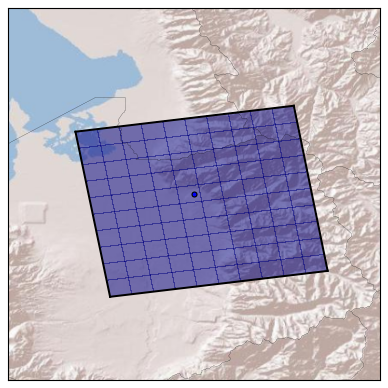

In [38]:
LATS_BOX = lat[x-box_radius:x+box_radius+1,y-box_radius:y+box_radius+1]
LONS_BOX = lon[x-box_radius:x+box_radius+1,y-box_radius:y+box_radius+1]

top_right_lat = LATS_BOX.max()
top_right_lon = LONS_BOX.min()

bot_left_lat = LATS_BOX.min()
bot_left_lon = LONS_BOX.max()

print bot_left_lon, top_right_lon
print bot_left_lat, top_right_lat

m = Basemap(llcrnrlon=MWlon-.3,  urcrnrlon=MWlon+.3,
            llcrnrlat=MWlat-.3, urcrnrlat=MWlat+.3)


m.drawcounties()
m.arcgisimage(service='World_Shaded_Relief')

m.pcolormesh(LONS_BOX, LATS_BOX, np.ones_like(LONS_BOX), alpha=.5)
m.scatter(MWlon, MWlat)

# Bottom Boundary
m.drawgreatcircle(LONS_BOX[0,-1], LATS_BOX[0,-1],
                  LONS_BOX[0,0], LATS_BOX[0,0],
                  color='k')

# Left Boundary
m.drawgreatcircle(LONS_BOX[0,0], LATS_BOX[0,0],
                  LONS_BOX[-1,0], LATS_BOX[-1,0],
                  color='k')

# Top Boundary
m.drawgreatcircle(LONS_BOX[-1,-1], LATS_BOX[-1,-1],
                  LONS_BOX[-1,0], LATS_BOX[-1,0],
                  color='k')

# Right Boundary
m.drawgreatcircle(LONS_BOX[-1,-1], LATS_BOX[-1,-1],
                  LONS_BOX[0,-1], LATS_BOX[0,-1],
                  color='k')

plt.title(stn)

plt.savefig('/uufs/chpc.utah.edu/common/home/u0553130/public_html/PhD/HRRR/OSG/area_current_HRRR/map.png')

# Box and Whisker

In [6]:
DATE = datetime(2018, 2, 10, 0)
var = 'TMP:2 m'
VALID, pollywog = get_hrrr_pollywog(DATE, 'TMP:2 m', MWlat, MWlon,
                                    verbose=False)

In [7]:
if var == 'TMP:2 m' or var == 'DPT:2 m':
    pollywog -= 273.15

In [8]:
variable = var.replace(':', '_').replace(' ', '_')
DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/%s/' % (variable)

p100 = np.array([])
p75 = np.array([])
p50 = np.array([])
p25 = np.array([])
p00 = np.array([])

for D in VALID:
    FILE = 'OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % (variable, D.month, D.day, D.hour)
    with h5py.File(DIR+FILE, 'r') as f:
        p100 = np.append(p100, f["p100"][x][y])
        p75 = np.append(p75, f["p75"][x][y])
        p50 = np.append(p50, f["p50"][x][y])
        p25 = np.append(p25, f["p25"][x][y])
        p00 = np.append(p00, f["p00"][x][y])

# Convert Units
if var == 'TMP:2 m' or var == 'DPT:2 m':
    p100 -= 273.15
    p75 -= 273.15
    p50 -= 273.15
    p25 -= 273.15
    p00 -= 273.15
    

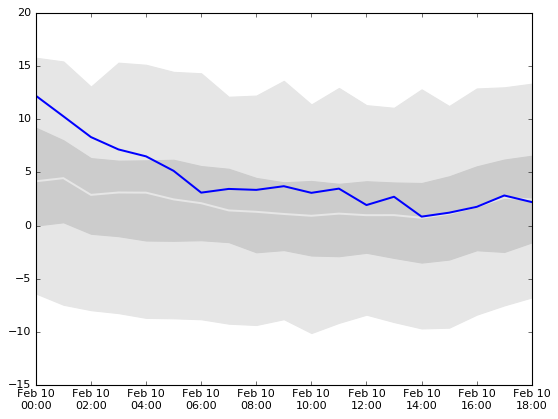

In [24]:
plt.fill_between(VALID, p100, p00, color=[.9,.9,.9])
plt.fill_between(VALID, p75, p25, color=[.8,.8,.8])
plt.plot(VALID, p50, color=[.9,.9,.9])
plt.plot(VALID, pollywog)

plt.gcf().axes[0].xaxis.set_major_formatter(formatter)

'/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/TMP_2_m/OSG_HRRR_TMP_2_m_m02_d10_h18_f00.h5'

/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/REFC_entire/OSG_HRRR_REFC_entire_m02_d18_h14_f00.h5
x1, y1: (90, 14.025)
x2, y2: (75, -10.0)
Hpoint: -3.875
m: 1.60166666667
b: -130.125
0 (78.824141519250773, -3.875)
-------
Station: (88.231323864252417, 15.6875)
-111.63201 -112.03877
40.60045 40.90858


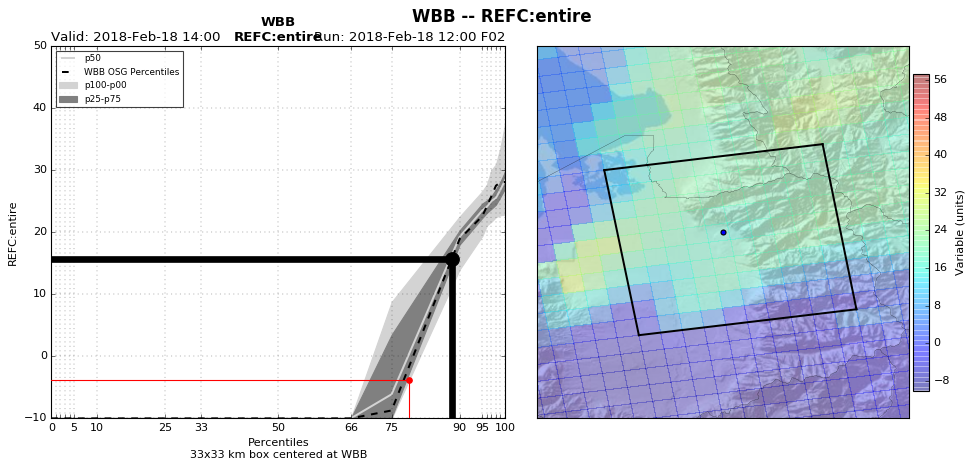

In [74]:
## Area Percentiles and Current HRRR
var = 'REFC:entire'
D = datetime(2018, 2, 18, 14)
f = 2

variable = var.replace(':', '_').replace(' ', '_')
DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/%s/' % (variable)

percentiles = [0,1,2,3,4,5,10,25,33,50,66,75,90,95,96,97,98,99,100]
box_radius = 5


if var == 'TMP:2 m':
    ymin = -20
    ymax = 30
elif var == 'DPT:2 m':
    ymin = -25
    ymax = 15
elif var == 'REFC:entire':
    ymin = -10
    ymax = 50
elif var == 'UVGRD:10 m':
    ymin = 0
    ymax = 20
elif var == 'UVGRD:80 m':
    ymin = 0
    ymax = 30
else:
    ymin = 0
    ymax = 20



## Get area OSG percentiles from the bounding box for each percentile
FILE = 'OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % ((variable, D.month, D.day, D.hour))
print DIR+FILE

with h5py.File(DIR+FILE, 'r') as ff:
    for i in percentiles:
        pp = ff["p%02d" %i][x-box_radius:x+box_radius+1,y-box_radius:y+box_radius+1]
        if i == 0:
            PP = pp
        else:
            PP = np.dstack([PP, pp])

## Convert Units
if var == 'TMP:2 m' or var == 'DPT:2 m':
    PP -= 273.15

## Clalculate area percentiles from the OSG percentiles
for i in range(19):
    p = np.percentile(PP[:,:,i], [0, 25, 50, 75, 100])
    if i == 0:
        area_P = p
    else:
        area_P = np.dstack([area_P, p])


## For this valid date, loop through each forecast hour

## HRRR Model Run date
RUN = D-timedelta(hours=f)

## Get HRRR data for this run
if var.split(':')[0] == 'UVGRD':
    # Calculate wind speed from U and V components
    level = var.split(':')[1]
    HU = get_hrrr_variable(RUN, 'UGRD:'+level, fxx=f, value_only=True, verbose=False)    
    HV = get_hrrr_variable(RUN, 'VGRD:'+level, fxx=f, value_only=True, verbose=False)
    speed = wind_uv_to_spd(HU['value'], HV['value'])
    H = HU
    H['value'] = speed
else:
    H = get_hrrr_variable(RUN, var, fxx=f, verbose=False)


## Convert units and get values in bounding box area
if var == 'TMP:2 m' or var == 'DPT:2 m':
    Hpoint = H['value'][x,y]-273.15
    Harea = H['value'][x-box_radius:x+box_radius+1,y-box_radius:y+box_radius+1]-273.15    
else:
    Hpoint = H['value'][x,y]
    Harea = H['value'][x-box_radius:x+box_radius+1,y-box_radius:y+box_radius+1]


## Calculate the HRRR percentiles in the boxed area for this run
HP = np.percentile(Harea, [0,25,50,75,100])


## --- Plot OSG percentiles ---------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15,6])

ax1.fill_between(percentiles, area_P[0][0], area_P[0][4],
                 color='lightgrey',
                 label='p100-p00',
                 zorder=1)
ax1.fill_between(percentiles, area_P[0][1], area_P[0][3],
                 color='grey',
                 label='p25-p75',
                 zorder=1)
ax1.plot(percentiles, area_P[0][2],
         color='lightgrey',
         label="p50",
         zorder=1)
## Plot all percentiles for each grid box
#for i in range(box_radius*2+1):
#    for j in range(box_radius*2+1):
#        plt.plot(percentiles, PP[i,j,:])


## Plot OSG percentiles for the single grid box nearest the station of interest
ax1.plot(percentiles, PP[box_radius,box_radius,:],
         linestyle='--',
         color='k',
         label='%s OSG Percentiles' % stn,
         zorder=1)


## --- Plot RUN percentiles -------------------------------------
# Linear interpolation to find the percentile for the value
for i in range(1):
    p100Hpoint = HP[i]
    p100PP = area_P[0][i]
    if p100Hpoint > np.max(p100PP):
        p100Y = p100Hpoint
        p100X = 100
        print "Hpoint > PP, exceeds p100", D, f
    elif p100Hpoint < np.min(p100PP):
        p100Y = p100Hpoint
        p100X = 0
        print "Hpoint < PP exceeds p00", D, f,
    else:
        p100y1 = np.min(filter(lambda x: x>=p100Hpoint, p100PP))
        p100y1_idx = np.where(p100PP==p100y1)[0][0]
        p100x1 = percentiles[p100y1_idx]
        p100y2 = p100PP[p100y1_idx-1] #y2 and y1 index are one behind x1,y1
        p100x2 = percentiles[p100y1_idx-1]
        p100m = (p100y2-p100y1)/(p100x2-p100x1)
        p100b = 0-p100m*p100x1+p100y1
        p100Y = p100Hpoint
        p100X = (p100Y-p100b)/p100m
        print 'x1, y1:', (p100x1, p100y1)
        print 'x2, y2:', (p100x2, p100y2)
        print 'Hpoint:', p100Hpoint
        print 'm:', p100m
        print 'b:', p100b
        print i, (p100X, p100Y)
        print "-------"
    ax1.axhline(p100Hpoint, xmax=p100X/100, color='r', linewidth=1, zorder=50)
    ax1.axvline(p100X, ymax=(p100Hpoint-ymin)/(ymax-ymin), color='r', linewidth=1, zorder=50)
    ax1.scatter(p100X, p100Hpoint, s=25, color='r', zorder=50)
## Plot value from current HRRR run for every grid box
#for i in range(box_radius*2+1):
#    for j in range(box_radius*2+1):
#        plt.axhline(Harea[i,j], linewidth=.1)

## Plot HRRR value for stn grid box for urrent HRRR run
# Linear interpolation to find the percentile for the value
stnPP = PP[box_radius,box_radius,:]
if Hpoint > np.max(stnPP):
    Y = Hpoint
    X = 100
    print "station Hpoint > PP, exceeds p100", D, f
elif Hpoint < np.min(stnPP):
    Y = Hpoint
    X = 0
    print "station Hpoint < PP, exceeds p00", D, f
else:
    y1 = np.min(filter(lambda x: x>=Hpoint, stnPP))
    y1_idx = np.where(stnPP==y1)[0][0]
    x1 = percentiles[y1_idx]
    y2 = stnPP[y1_idx-1]
    x2 = percentiles[y1_idx-1]
    m = (y2-y1)/(x2-x1)
    b = 0-m*x1+y1
    Y = Hpoint
    X = (Y-b)/m
    print 'Station:', (X, Y)
ax1.axhline(Hpoint, xmax=X/100, color='k', lw=6, zorder=100)
ax1.axvline(X, ymax=(Hpoint-ymin)/(ymax-ymin), color='k', lw=6, zorder=100)
ax1.scatter(X, Hpoint, s=150, color='k', zorder=100)


## --- Other Plot Elements --------------------------------------
ax1.grid()
ax1.legend(loc='upper left')

ax1.set_xlabel('Percentiles\n%sx%s km box centered at %s' % (np.shape(PP)[0]*3, np.shape(PP)[0]*3, stn))
tick_labels = [0,'','','','',5, 10, 25, 33, 50, 66, 75, 90, 95, '', '', '','',100]
ax1.set_xticks(percentiles)
ax1.set_xticklabels(tick_labels)
ax1.set_xlim([0,100])
ax1.set_ylabel(var)
ax1.set_ylim([ymin, ymax])

ax1.set_title('Valid: %s' % H['valid'].strftime('%Y-%b-%d %H:%M'), loc='Left')
ax1.set_title('%s\n%s' % (stn, var), loc='Center', fontweight='bold')
ax1.set_title('Run: %s F%02d' % (H['anlys'].strftime("%Y-%b-%d %H:%M"), f), loc='right')


### Map
plt.sca(ax2)
LATS_BOX = lat[x-box_radius:x+box_radius+1,y-box_radius:y+box_radius+1]
LONS_BOX = lon[x-box_radius:x+box_radius+1,y-box_radius:y+box_radius+1]

top_right_lat = LATS_BOX.max()
top_right_lon = LONS_BOX.min()

bot_left_lat = LATS_BOX.min()
bot_left_lon = LONS_BOX.max()

print bot_left_lon, top_right_lon
print bot_left_lat, top_right_lat

m = Basemap(llcrnrlon=MWlon-.3,  urcrnrlon=MWlon+.3,
            llcrnrlat=MWlat-.3, urcrnrlat=MWlat+.3)


m.drawcounties()
m.arcgisimage(service='World_Shaded_Relief')

m.pcolormesh(lon, lat, H['value'], alpha=.3)
cb = plt.colorbar(orientation='vertical', pad=0.01, shrink=0.85)
cb.set_label('Variable (units)')

m.scatter(MWlon, MWlat)

# Bottom Boundary
m.drawgreatcircle(LONS_BOX[0,-1], LATS_BOX[0,-1],
                  LONS_BOX[0,0], LATS_BOX[0,0],
                  color='k')

# Left Boundary
m.drawgreatcircle(LONS_BOX[0,0], LATS_BOX[0,0],
                  LONS_BOX[-1,0], LATS_BOX[-1,0],
                  color='k')

# Top Boundary
m.drawgreatcircle(LONS_BOX[-1,-1], LATS_BOX[-1,-1],
                  LONS_BOX[-1,0], LATS_BOX[-1,0],
                  color='k')

# Right Boundary
m.drawgreatcircle(LONS_BOX[-1,-1], LATS_BOX[-1,-1],
                  LONS_BOX[0,-1], LATS_BOX[0,-1],
                  color='k')

plt.suptitle('%s -- %s' % (stn, var))

plt.savefig('/uufs/chpc.utah.edu/common/home/u0553130/public_html/PhD/HRRR/OSG/area_current_HRRR/map.png')

In [63]:
Harea

array([[ -0.25  ,   7.5   ,   9.1875,   6.125 ,  -0.875 ,  -3.5   ,
         -3.875 ,  -2.8125,   0.25  ,  -1.625 ,  -0.4375],
       [ -0.75  ,  10.625 ,  15.25  ,  16.1875,  12.5   ,   8.    ,
          3.75  ,   3.8125,   3.625 ,   3.3125,   1.5625],
       [  5.375 ,   9.5   ,  15.5   ,  18.3125,  18.5   ,  16.    ,
         12.625 ,   9.8125,   7.875 ,   6.8125,   7.375 ],
       [ 14.5625,  12.875 ,  14.8125,  17.8125,  19.125 ,  19.25  ,
         18.9375,  16.6875,  15.5   ,  14.0625,  13.25  ],
       [ 19.125 ,  18.125 ,  17.6875,  17.625 ,  17.3125,  18.125 ,
         18.8125,  20.3125,  20.5   ,  19.5   ,  17.9375],
       [ 23.1875,  19.9375,  19.3125,  18.0625,  16.8125,  15.6875,
         17.5   ,  19.875 ,  20.8125,  21.8125,  20.8125],
       [ 21.5625,  20.8125,  19.875 ,  18.625 ,  18.    ,  17.5   ,
         17.6875,  19.    ,  19.875 ,  20.875 ,  21.1875],
       [ 16.4375,  20.0625,  21.125 ,  20.9375,  19.75  ,  20.0625,
         19.4375,  19.0625,  19.5   ,  19.6